In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define the directory containing the data
data_dir = 'benzene_data'

# List all .dat files
files = sorted(glob.glob(os.path.join(data_dir, '*.dat')))

print(f"Found {len(files)} files.")
for f in files[:5]:
    print(f)

Found 30 files.
benzene_data/intensity_1033.356.dat
benzene_data/intensity_1035.173.dat
benzene_data/intensity_1139.118.dat
benzene_data/intensity_1161.26.dat
benzene_data/intensity_1162.716.dat


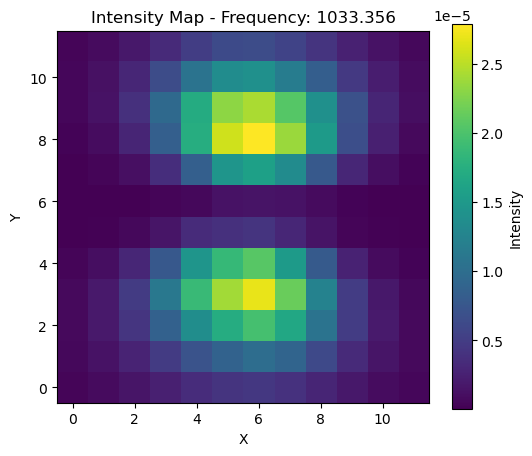

Data shape: (12, 12)
Min intensity: 5.539602329803724e-09
Max intensity: 2.7840315065471093e-05


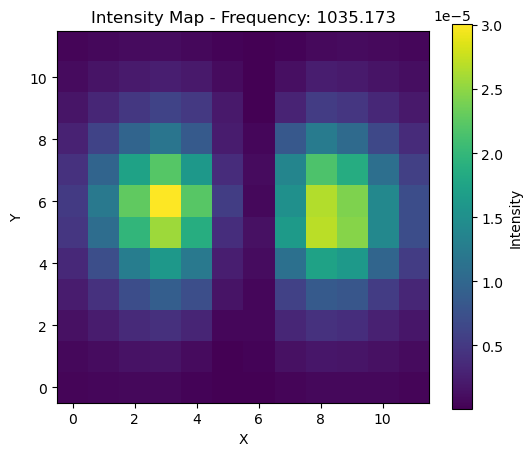

Data shape: (12, 12)
Min intensity: 9.292839720970795e-10
Max intensity: 3.0058986511853143e-05


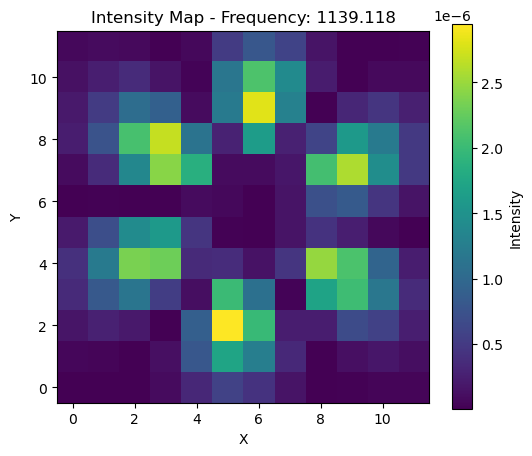

Data shape: (12, 12)
Min intensity: 1.5177870150297303e-09
Max intensity: 2.9451833744910888e-06


In [2]:
def plot_intensity_map(file_path):
    """
    Reads a .dat file and plots the intensity map.
    """
    try:
        # Read the data into a numpy array
        data = np.loadtxt(file_path)
        
        # Extract frequency from filename for the title
        filename = os.path.basename(file_path)
        frequency = filename.replace('intensity_', '').replace('.dat', '')
        
        plt.figure(figsize=(6, 5))
        plt.imshow(data, cmap='viridis', origin='lower')
        plt.colorbar(label='Intensity')
        plt.title(f'Intensity Map - Frequency: {frequency}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
        
        print(f"Data shape: {data.shape}")
        print(f"Min intensity: {data.min()}")
        print(f"Max intensity: {data.max()}")
        
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Plot the first few files
for file_path in files[:3]:
    plot_intensity_map(file_path)

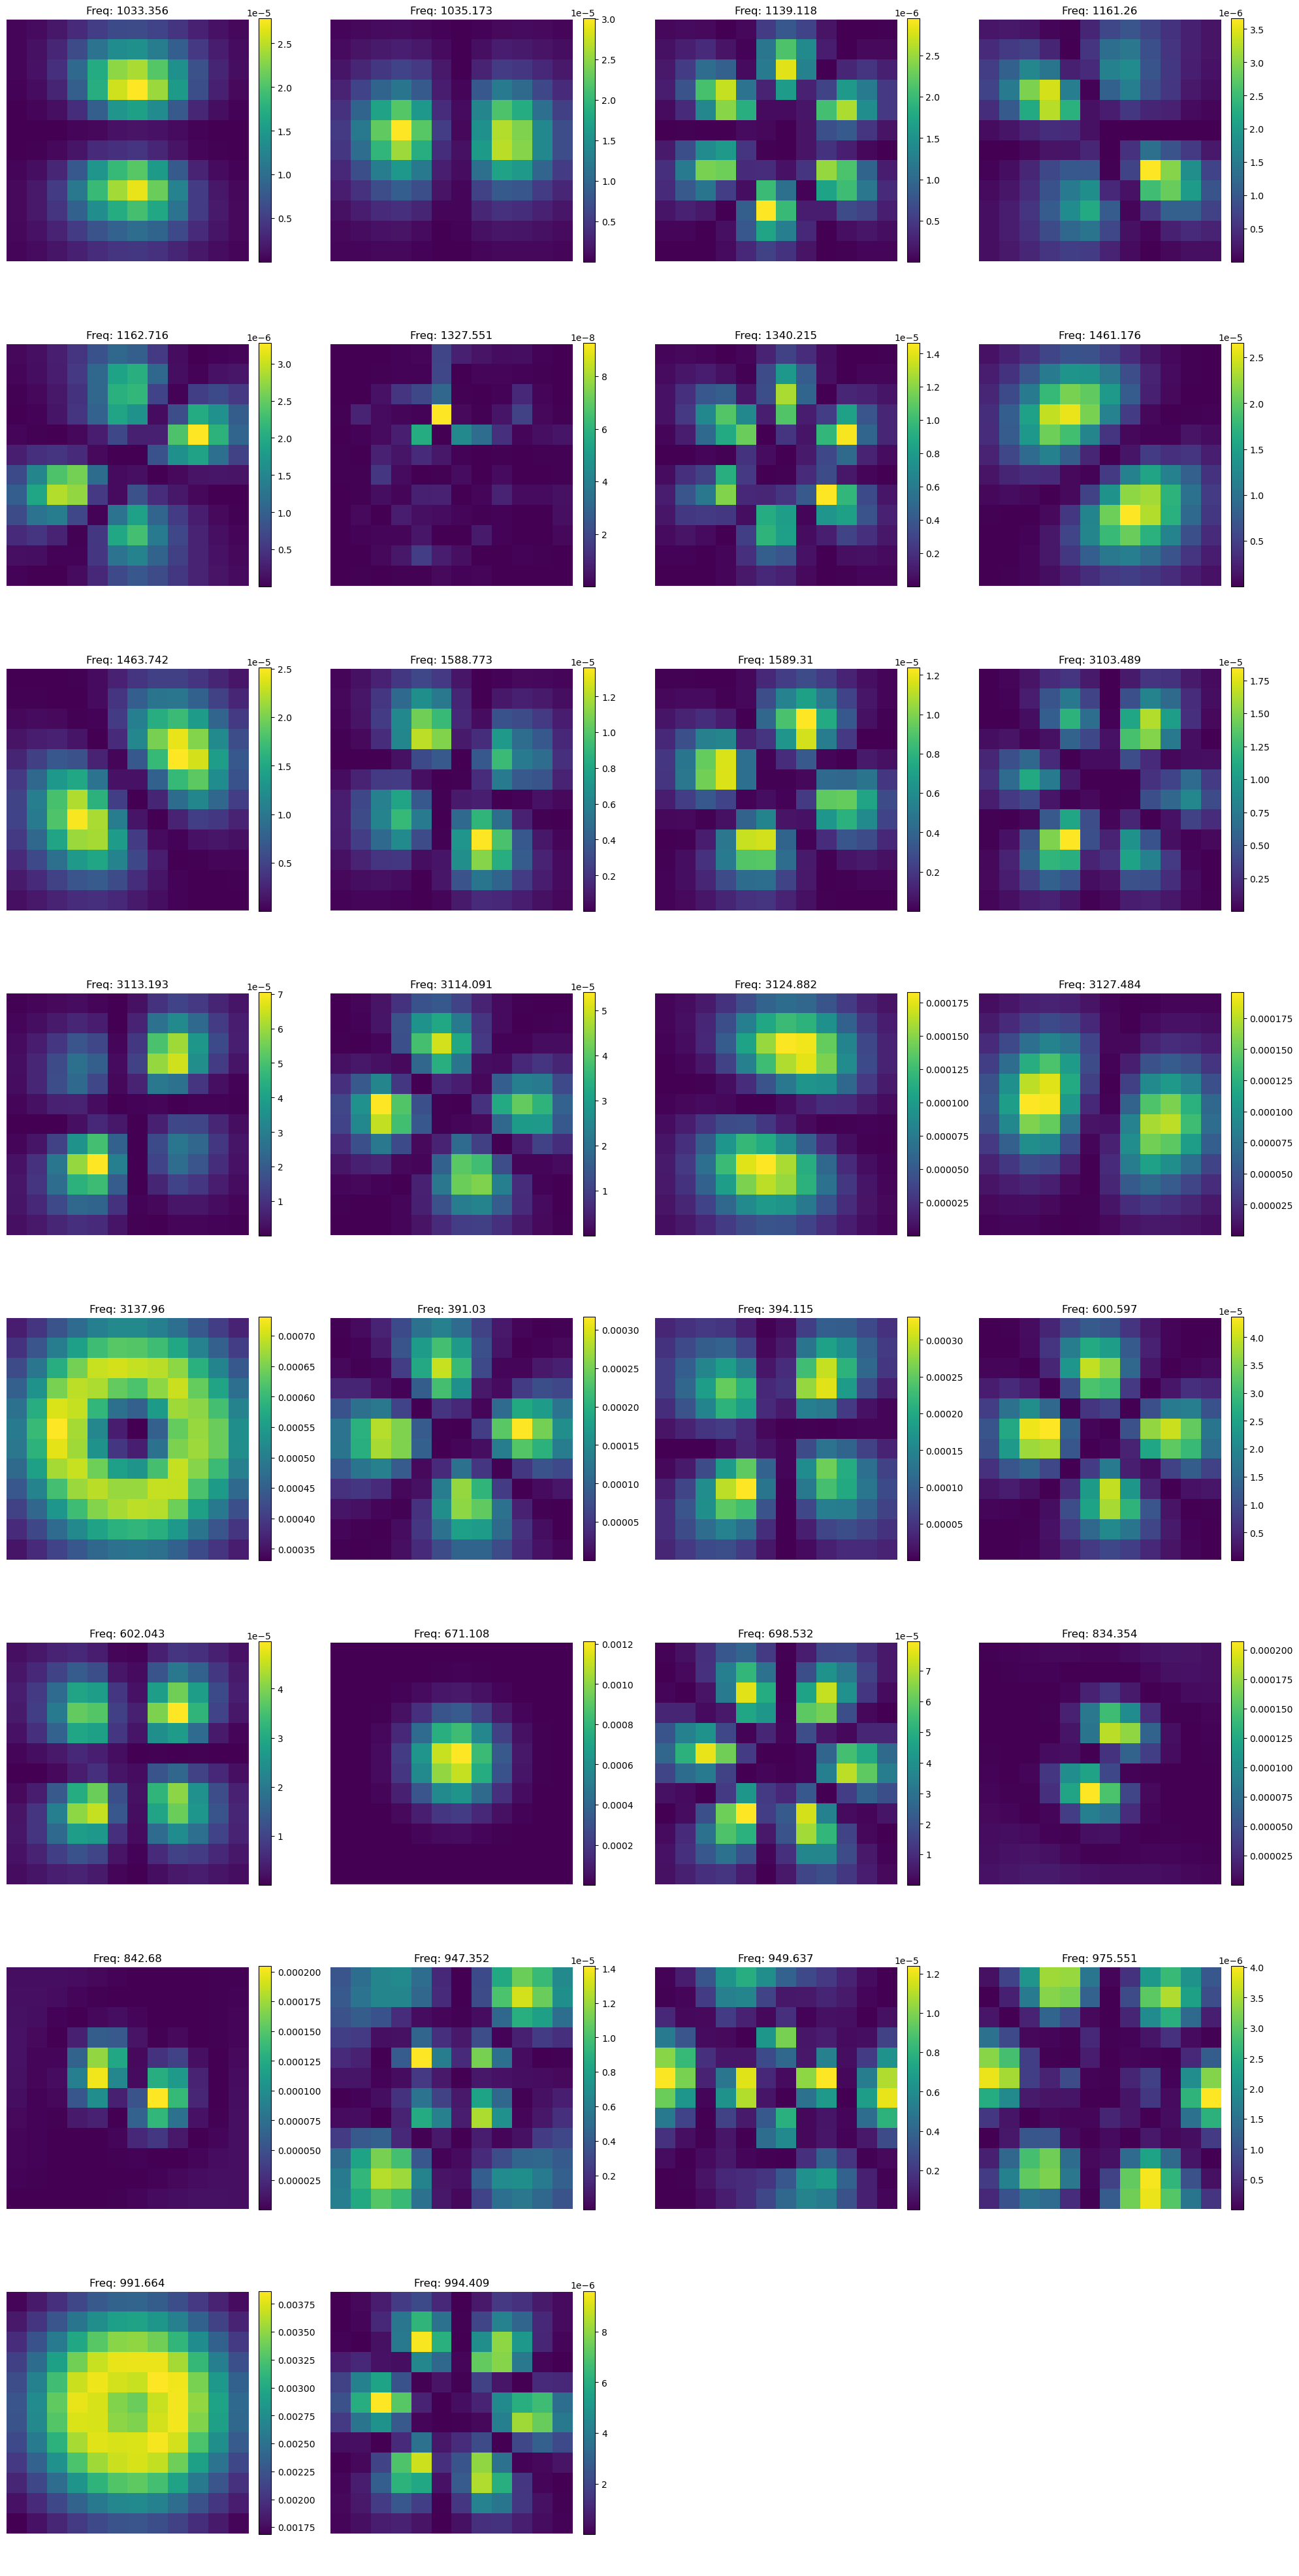

In [3]:
# Plot all files in a grid
num_files = len(files)
cols = 4
rows = (num_files + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, file_path in enumerate(files):
    try:
        data = np.loadtxt(file_path)
        filename = os.path.basename(file_path)
        frequency = filename.replace('intensity_', '').replace('.dat', '')
        
        im = axes[i].imshow(data, cmap='viridis', origin='lower')
        axes[i].set_title(f'Freq: {frequency}')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

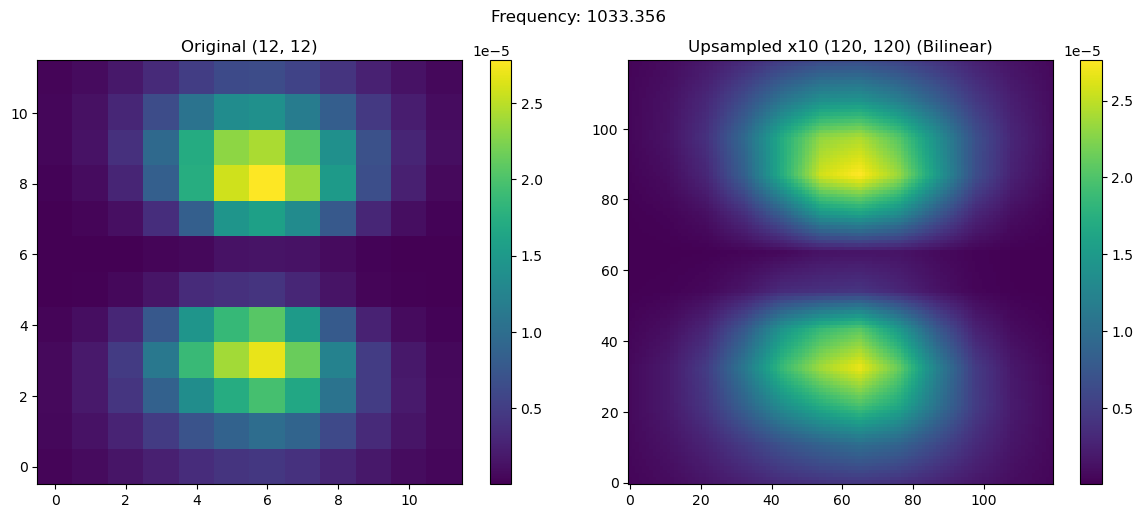

In [4]:
from scipy.ndimage import zoom

def plot_upsampled_intensity(file_path, scale_factor=4):
    """
    Reads a .dat file, upsamples it using bilinear interpolation, and plots both.
    """
    try:
        data = np.loadtxt(file_path)
        
        # Upsample using bilinear interpolation (order=1). Use order=0 for nearest, order=3 for bicubic.
        high_res_data = zoom(data, scale_factor, order=1)
        
        filename = os.path.basename(file_path)
        frequency = filename.replace('intensity_', '').replace('.dat', '')
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original
        im1 = axes[0].imshow(data, cmap='viridis', origin='lower')
        axes[0].set_title(f'Original {data.shape}')
        plt.colorbar(im1, ax=axes[0])
        
        # Upsampled
        im2 = axes[1].imshow(high_res_data, cmap='viridis', origin='lower')
        axes[1].set_title(f'Upsampled x{scale_factor} {high_res_data.shape} (Bilinear)')
        plt.colorbar(im2, ax=axes[1])
        
        plt.suptitle(f'Frequency: {frequency}')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Test with the first file
if len(files) > 0:
    plot_upsampled_intensity(files[0], scale_factor=10)

In [5]:
import numpy as np
import glob
import os
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Define the directory containing the data
data_dir = 'benzene_data'
files = sorted(glob.glob(os.path.join(data_dir, '*.dat')))

# Initialize the result array: 100 bins, 256x256 resolution
result_array = np.zeros((100, 256, 256))
bin_counts = np.zeros(100)

print(f"Processing {len(files)} files...")

for file_path in files:
    try:
        # Extract frequency from filename
        filename = os.path.basename(file_path)
        # Filename format expected: 'intensity_<freq>.dat'
        freq_str = filename.replace('intensity_', '').replace('.dat', '')
        frequency = float(freq_str)
        
        # Check if frequency is within range 1-4000
        if 1 <= frequency <= 4000:
            # Calculate bin index (0-99)
            # Bin 0: 1-40, Bin 1: 41-80, ..., Bin 99: 3961-4000
            bin_idx = int((frequency - 1) / 40)
            
            if 0 <= bin_idx < 100:
                # Load data
                data = np.loadtxt(file_path)
                
                # Normalize data to [0, 1]
                if data.max() > data.min():
                    data_norm = (data - data.min()) / (data.max() - data.min())
                else:
                    data_norm = np.zeros_like(data)
                
                # Resize to 256x256
                # Calculate zoom factors
                current_shape = data_norm.shape
                zoom_factors = (256 / current_shape[0], 256 / current_shape[1])
                
                # Upsample using bilinear interpolation (order=1)
                data_resized = zoom(data_norm, zoom_factors, order=1)
                
                # Accumulate
                if data_resized.shape == (256, 256):
                    result_array[bin_idx] += data_resized
                    bin_counts[bin_idx] += 1
                
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Processing complete.")
print(f"Result array shape: {result_array.shape}")
print(f"Non-empty bins: {np.count_nonzero(bin_counts)}")

Processing 30 files...
Processing complete.
Result array shape: (100, 256, 256)
Non-empty bins: 17


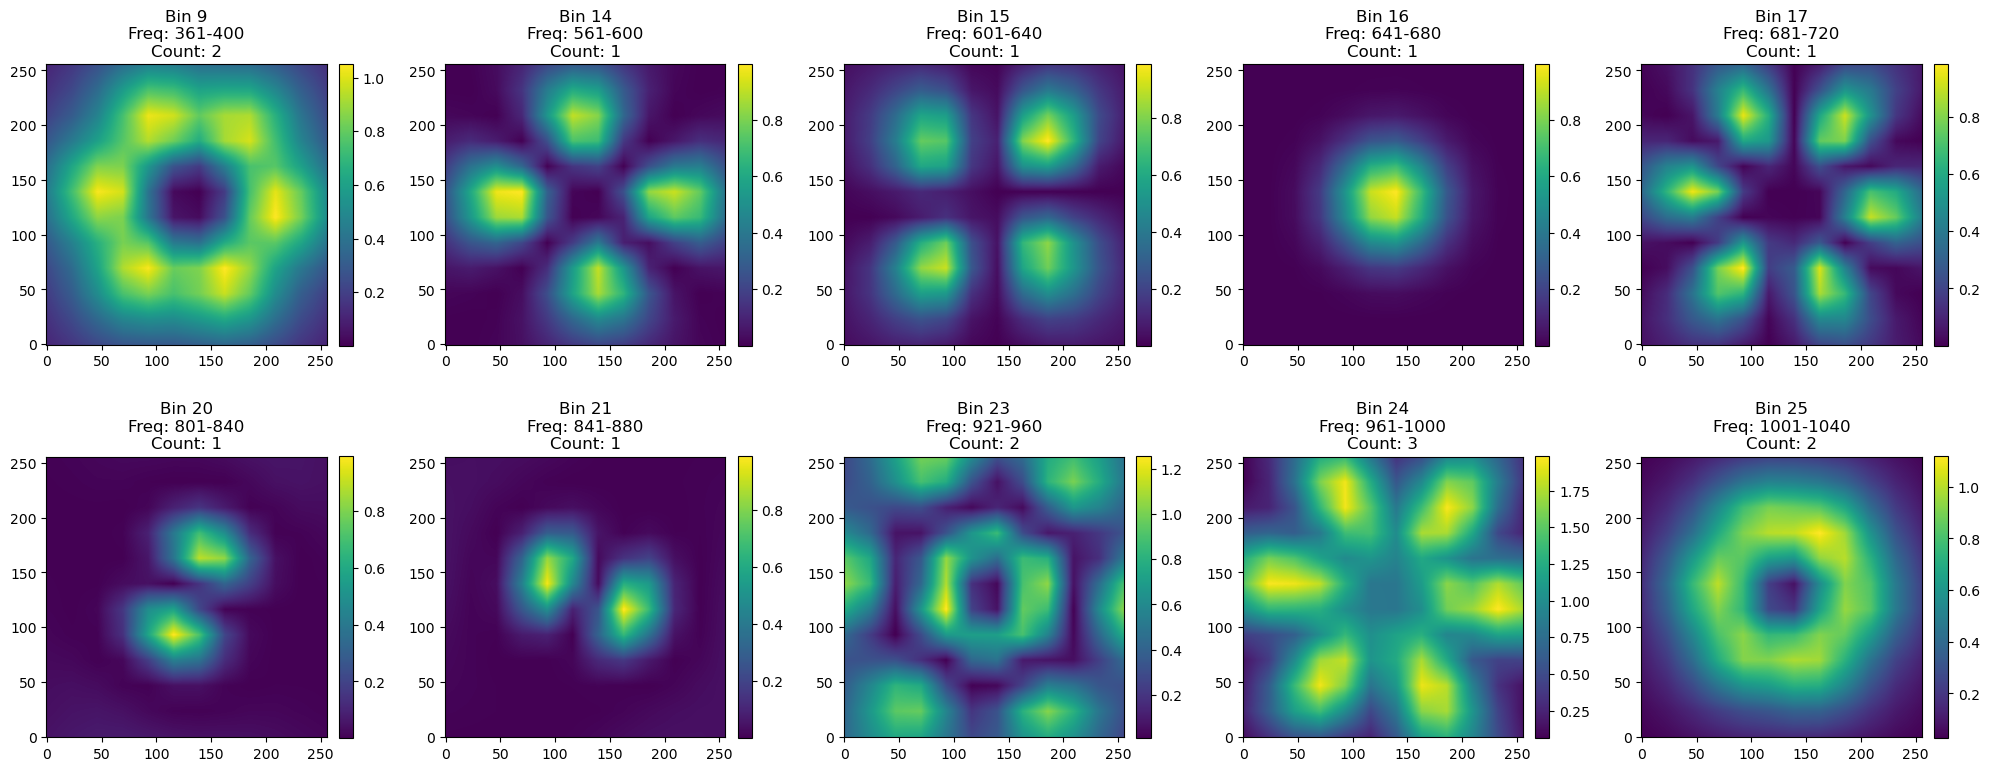

In [6]:
import matplotlib.pyplot as plt

# Visualize a few bins
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Find indices of bins that have data
populated_bins = np.where(bin_counts > 0)[0]

for i, ax in enumerate(axes):
    if i < len(populated_bins):
        bin_idx = populated_bins[i]
        im = ax.imshow(result_array[bin_idx], cmap='viridis', origin='lower')
        ax.set_title(f'Bin {bin_idx}\nFreq: {bin_idx*40+1}-{(bin_idx+1)*40}\nCount: {int(bin_counts[bin_idx])}')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import glob
import os
from scipy.ndimage import zoom

# Initialize the result array of shape (100, 256, 256)
result_array = np.zeros((100, 256, 256))
bin_counts = np.zeros(100)

# Define the directory containing the data
data_dir = 'benzene_data'
files = sorted(glob.glob(os.path.join(data_dir, '*.dat')))

print(f"Found {len(files)} files. Starting processing...")

for file_path in files:
    try:
        # Extract frequency from filename
        filename = os.path.basename(file_path)
        # Assuming filename format like 'intensity_123.45.dat'
        freq_str = filename.replace('intensity_', '').replace('.dat', '')
        frequency = float(freq_str)
        
        # Check if frequency is within the range 1-4000
        if 1 <= frequency <= 4000:
            # Determine the bin index (0 to 99)
            # Each bin has a width of 40
            bin_idx = int((frequency - 1) / 40)
            bin_idx = min(bin_idx, 99)  # Ensure it doesn't exceed 99
            
            # Load the data
            data = np.loadtxt(file_path)
            
            # Normalize the data (0 to 1)
            if data.max() > data.min():
                data_norm = (data - data.min()) / (data.max() - data.min())
            else:
                data_norm = np.zeros_like(data)
            
            # Upsample to 256x256
            # Calculate zoom factors
            zoom_factor_x = 256 / data.shape[0]
            zoom_factor_y = 256 / data.shape[1]
            
            # Apply zoom with bilinear interpolation (order=1)
            data_resized = zoom(data_norm, (zoom_factor_x, zoom_factor_y), order=1)
            
            # Accumulate the result in the corresponding bin
            # Ensure the shape is exactly 256x256
            if data_resized.shape == (256, 256):
                result_array[bin_idx] += data_resized
                bin_counts[bin_idx] += 1
            else:
                # In case of slight rounding issues, we can crop or pad, but usually zoom works.
                # For now, we skip if shape doesn't match to avoid errors, or we could force resize.
                pass

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Processing complete.")
print(f"Result array shape: {result_array.shape}")
print(f"Number of images summed per bin: {bin_counts}")

Found 30 files. Starting processing...
Processing complete.
Result array shape: (100, 256, 256)
Number of images summed per bin: [0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 2.
 3. 2. 0. 0. 1. 2. 0. 0. 0. 2. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [8]:
result_array.shape

(100, 256, 256)

In [11]:
import torch 
import sys
sys.path.append('/home/sethih1/masque_new/ters_gen')

device = 'cuda'
model_path = "/scratch/phys/sin/sethih1/Extended_TERS_data/run_planar_again_final_complete/run_planar_npz_0.1/models/best_model.pt"
model = torch.load(model_path, map_location=device)

In [17]:
img = torch.from_numpy(result_array).to(device).float().unsqueeze(0)

In [35]:
pred = model(img)

In [36]:
pred_cpu = pred.detach().squeeze(0,1).cpu()

In [37]:
pred_cpu.shape

torch.Size([256, 256])

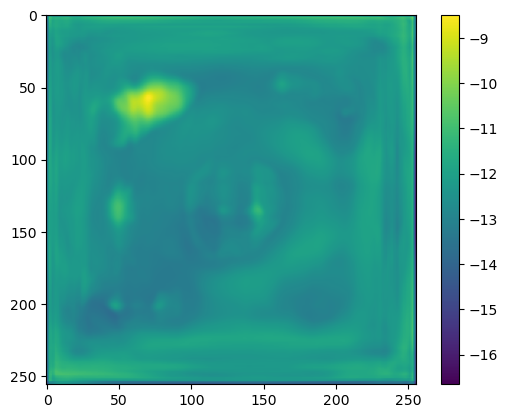

In [40]:
plt.imshow(pred_cpu)
plt.colorbar()

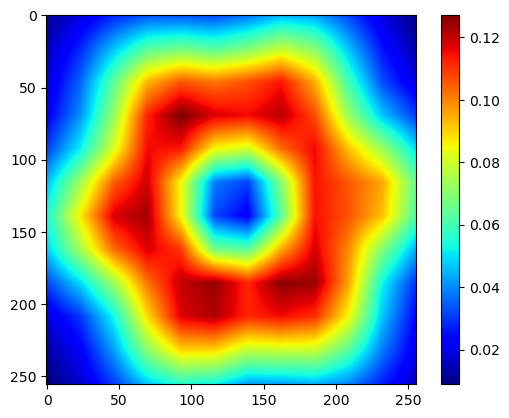

In [41]:
plt.imshow(torch.mean(img, dim = 1).squeeze(0).cpu(), cmap='jet')
plt.colorbar()